<a href="https://colab.research.google.com/github/WexQuasExort/Binary-Search-Tree/blob/master/Unet_TL_12k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.layers import Dense, Dropout, Activation, Flatten  ,BatchNormalization, Input, Conv2D,Conv2DTranspose, Concatenate,MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Convolution2D, MaxPooling2D ,UpSampling2D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from keras.models import Sequential
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np  
import random
import pickle
import cv2
import bz2
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
arabic_test=np.load('/content/drive/MyDrive/train/arabic_28x28_inversed.npy',allow_pickle=True)

In [3]:
with bz2.BZ2File ("/content/drive/MyDrive/128x128_train/myData12k.pkl", "rb") as f2:
    X_train, Y_train, X_val, Y_val = pickle.load(f2)

In [4]:
with bz2.BZ2File ("/content/drive/MyDrive/128x128_train/myDataArabic.pkl", "rb") as f2:
    arabic_dataset = pickle.load(f2)

In [5]:
# squeeze it and have fun
arabic_dataset= np.squeeze(arabic_dataset)
arabic_dataset = np.repeat(arabic_dataset[...,np.newaxis],3,-1)
arabic_dataset.shape

(10000, 128, 128, 3)

In [4]:
X_train = np.repeat(X_train[...,np.newaxis],3,-1)
Y_train = np.repeat(Y_train[...,np.newaxis],1,-1)
X_val = np.repeat(X_val[...,np.newaxis],3,-1)
Y_val = np.repeat(Y_val[...,np.newaxis],1,-1)

In [5]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(10000, 128, 128, 3)
(10000, 128, 128, 1)
(2000, 128, 128, 3)
(2000, 128, 128, 1)


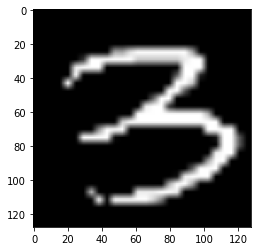

TypeError: ignored

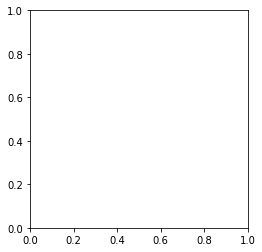

In [ ]:
X_train.shape
for img in X_train[:1] :
    plt.imshow(img,  cmap ="gray")
    plt.show()
for img in Y_train[:1] :
    plt.imshow(img,  cmap ="gray")
    plt.show()

In [6]:
print(X_val.shape)
print(Y_val.shape)
print(X_train.shape)
print(Y_train.shape)

(2000, 128, 128, 3)
(2000, 128, 128, 1)
(10000, 128, 128, 3)
(10000, 128, 128, 1)


In [ ]:
X_training_data = []
# rezising images and reshaping arrays
for img in arabic_test:
    try:
        image  = cv2.resize(img, (128,128))
        X_training_data.append([image])
    except Exception as e:
        pass
X_training_data = np.array(X_training_data, dtype=object)
X_training_data = np.array(X_training_data).reshape(-1, 128,128)
X_training_data.shape

NameError: ignored

In [ ]:
X_training_data = np.repeat(X_training_data[...,np.newaxis],3,-1)

In [ ]:
X_training_data.shape

In [7]:
loss_func1 = "categorical_crossentropy"
loss_func2 = "binary_crossentropy"
activation_func1 = "softmax"
activation_func2 = "sigmoid"

In [8]:
# https://github.com/nikhilroxtomar/Semantic-Segmentation-Architecture/blob/main/TensorFlow/resnet50_unet.py
# https://github.com/zhixuhao/unet
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p
  
def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def unet(pretrained, input_shape):
  inputs = Input(input_shape)

  if pretrained:
    """ Pre-trained ResNet50 Model """
    resnet50 = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    """ Encoder """
    s1 = resnet50.get_layer("input_1").output           
    s2 = resnet50.get_layer("conv1_relu").output        
    s3 = resnet50.get_layer("conv2_block3_out").output  
    s4 = resnet50.get_layer("conv3_block4_out").output  

    """ Bridge """
    b1 = resnet50.get_layer("conv4_block6_out").output  #bottle neck
  else:
    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)
    """ Bridge """
    b1 = conv_block(p4, 1024)

  """ Decoder """
  d1 = decoder_block(b1, s4, 512)                     
  d2 = decoder_block(d1, s3, 256)                     
  d3 = decoder_block(d2, s2, 128)                     
  d4 = decoder_block(d3, s1, 64)                      

  """ Output """
  outputs = Conv2D(1, 1, padding="same", activation= activation_func2 )(d4)

  if pretrained:
    model = Model(inputs, outputs, name="ResNet50_U-Net")
  else:
    model = Model(inputs, outputs, name="U-Net")
#   model.summary()
  return model

In [9]:
filepath = "/content/best/sample{epoch:03d}-val_acc_{val_accuracy}.hdf5"
checkpoint = ModelCheckpoint(filepath,
                              monitor="val_accuracy", verbose=0,
                              save_best_only=True, 
                              save_weights_only=False, mode='max')

In [10]:
model = unet(False,(128,128,3))
model.compile(loss =loss_func2, optimizer = "adam", metrics =['accuracy'])

In [11]:
print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

(10000, 128, 128, 3)
(10000, 128, 128, 1)
(2000, 128, 128, 3)
(2000, 128, 128, 1)


In [ ]:
# for i in range(len(X_train)):
#     if X_train[i].shape[2] != X_val[i].shape[2]:
#         print(i) 


In [ ]:
history = model.fit(X_train,Y_train,batch_size= 64,validation_data=(X_val, Y_val), epochs = 30,verbose =1,callbacks=[checkpoint])

Epoch 1/30
157/157 [==============================] - 180s 954ms/step - loss: 0.1062 - accuracy: 0.9749 - val_loss: 0.1755 - val_accuracy: 0.9482
Epoch 2/30
157/157 [==============================] - 140s 891ms/step - loss: 0.0462 - accuracy: 0.9836 - val_loss: 0.1952 - val_accuracy: 0.9651
Epoch 3/30
157/157 [==============================] - 140s 893ms/step - loss: 0.0390 - accuracy: 0.9845 - val_loss: 0.1820 - val_accuracy: 0.9631
Epoch 4/30
157/157 [==============================] - 142s 904ms/step - loss: 0.0355 - accuracy: 0.9853 - val_loss: 0.0483 - val_accuracy: 0.9843
Epoch 5/30
157/157 [==============================] - 142s 903ms/step - loss: 0.0339 - accuracy: 0.9857 - val_loss: 0.0375 - val_accuracy: 0.9850
Epoch 6/30
157/157 [==============================] - 142s 904ms/step - loss: 0.0326 - accuracy: 0.9860 - val_loss: 0.0339 - val_accuracy: 0.9856
Epoch 7/30
157/157 [==============================] - 138s 882ms/step - loss: 0.0315 - accuracy: 0.9864 - val_loss: 0.0491 -

In [11]:
model.save("/content/drive/MyDrive/model_UNet_No12k_CNN")

In [8]:
loaded_model = tf.keras.models.load_model('/content/drive/MyDrive/model_UNet_No12k_CNN')

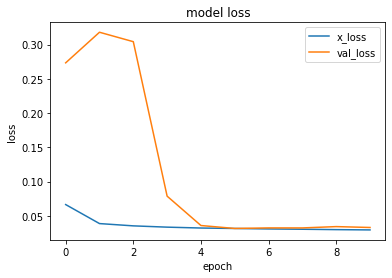

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['x_loss', 'val_loss'])
plt.show()

In [9]:
prediction_self = loaded_model.predict([arabic_dataset])
print(prediction_self.shape)

313/313 [==============================] - 57s 142ms/step
(10000, 128, 128, 1)


In [ ]:
# plt.imshow(X_test[0].reshape(128,128,3), cmap="gray")
# plt.show()
# plt.imshow(prediction[0].reshape(128,128), cmap="gray")
# plt.show()

In [10]:
predicted_sample = prediction_self.astype('float32')
# print(prediction[0])
threshold_arabic = []
for img in predicted_sample:
              #  img, th1 = cv2.threshold(img , 127, 0, cv2.THRESH_BINARY)
               (img, th1) = cv2.threshold(img , 0.5, 1, cv2.THRESH_BINARY)
               threshold_arabic.append(th1)   

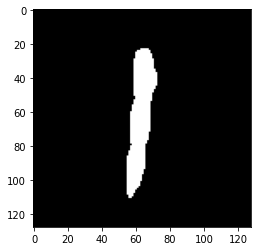

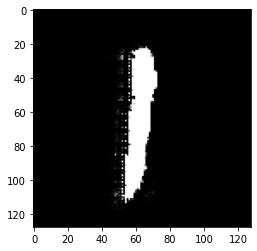

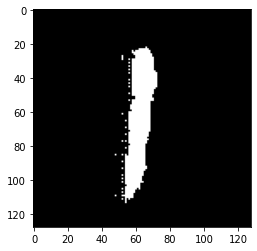

In [11]:
plt.imshow(arabic_dataset[1].reshape(128,128,3), cmap="gray")
plt.show()
plt.imshow(prediction_self[1].reshape(128,128), cmap="gray")
plt.show()
plt.imshow(threshold_arabic[1].reshape(128,128), cmap="gray")
plt.show()

In [12]:
plt.imshow(arabic_test[3].reshape(28,28), cmap="gray")
plt.show()
plt.imshow(arabic_dataset[3].reshape(128,128,3), cmap="gray")
plt.show()
plt.imshow(prediction_self[3].reshape(128,128), cmap="gray")
plt.show()
plt.imshow(threshold_arabic[3].reshape(128,128), cmap="gray")
plt.show()

NameError: ignored

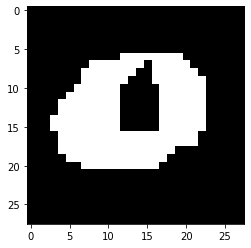

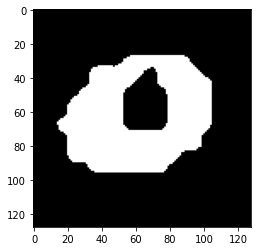

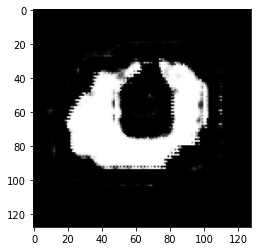

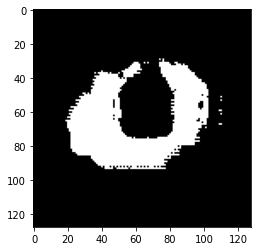

In [ ]:
plt.imshow(arabic_test[0].reshape(28,28), cmap="gray")
plt.show()
plt.imshow(arabic_dataset[0].reshape(128,128,3), cmap="gray")
plt.show()
plt.imshow(prediction_self[0].reshape(128,128), cmap="gray")
plt.show()
plt.imshow(threshold_arabic[0].reshape(128,128), cmap="gray")
plt.show()

In [ ]:
print(predicted_sample[0])

[[[2.13068677e-04]
  [1.19055825e-04]
  [9.81155026e-05]
  ...
  [1.16651740e-04]
  [1.13250797e-04]
  [1.58601266e-04]]

 [[7.88972175e-05]
  [1.11682159e-04]
  [3.72339418e-05]
  ...
  [2.80032546e-04]
  [6.62878301e-05]
  [1.41712371e-04]]

 [[1.32644942e-04]
  [5.89108859e-05]
  [7.00640594e-05]
  ...
  [1.61479111e-04]
  [1.17537849e-04]
  [1.12543712e-04]]

 ...

 [[8.81140004e-05]
  [5.36090847e-05]
  [4.97992805e-05]
  ...
  [5.29156314e-05]
  [1.57831637e-05]
  [4.82101932e-05]]

 [[1.20796998e-04]
  [4.08487431e-05]
  [3.65401647e-05]
  ...
  [2.39586007e-05]
  [4.03066551e-05]
  [5.51837074e-05]]

 [[1.62630444e-04]
  [9.58623423e-05]
  [3.91931317e-05]
  ...
  [8.41022338e-05]
  [3.81229875e-05]
  [1.54630456e-04]]]


In [ ]:
if __name__ == "__main__":
    model = unet(False,(128,128,3))
    # X_training_data = np.asarray(X_training_data).astype('float32')
    prediction = model.predict([arabic_dataset])
    # model.summary()

313/313 [==============================] - 53s 131ms/step


In [ ]:
model.save("/content/drive/MyDrive/model_No100_CNN")

In [ ]:
print(prediction.shape)

In [ ]:
predicted_sample = prediction.astype('float32') 
# print(prediction[0])
threshold_arabic = []
for img in predicted_sample:
              #  img, th1 = cv2.threshold(img , 127, 0, cv2.THRESH_BINARY)
               (img, th1) = cv2.threshold(img , 0.5, 1, cv2.THRESH_BINARY)
               threshold_arabic.append(th1)  

In [ ]:
import skimage.color
import skimage.filters

In [ ]:
prediction[0]

array([[[0.50000066],
        [0.49999964],
        [0.5000006 ],
        ...,
        [0.5       ],
        [0.5000005 ],
        [0.49999917]],

       [[0.5000001 ],
        [0.49999952],
        [0.5000005 ],
        ...,
        [0.5       ],
        [0.5       ],
        [0.5000008 ]],

       [[0.5000003 ],
        [0.5000002 ],
        [0.5000009 ],
        ...,
        [0.49999988],
        [0.5000018 ],
        [0.49999988]],

       ...,

       [[0.49999917],
        [0.5       ],
        [0.49999964],
        ...,
        [0.50000006],
        [0.49999976],
        [0.49999976]],

       [[0.50000095],
        [0.5000008 ],
        [0.5000005 ],
        ...,
        [0.50000024],
        [0.50000036],
        [0.5000001 ]],

       [[0.5000002 ],
        [0.5       ],
        [0.5000006 ],
        ...,
        [0.5000003 ],
        [0.5000003 ],
        [0.50000006]]], dtype=float32)

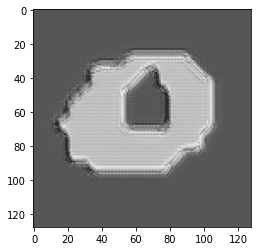

NameError: ignored

In [ ]:
plt.imshow(prediction[0].reshape(128,128), cmap="gray")
plt.show()
plt.imshow(threshold_arabic[0].reshape(128,128), cmap="gray")
plt.show()
blurred_image = skimage.filters.gaussian(prediction[0], sigma=1)
plt.imshow(blurred_image.reshape(128,128), cmap="gray")
plt.show()
print(blurred_image)